In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2
from cvaei.examples.two_moons import TwoMoons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


# Initialise the Model

In [4]:
ma2 = MovingAverage2()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = ma2.prepare_data(100000)
observed_data = ma2.observed_data()
ma2.check_normalizer()


Training Theta Shape: torch.Size([100000, 2])
Training Data Shape: torch.Size([100000, 100])
Validation Theta Shape: torch.Size([10000, 2])
Validation Data Shape: torch.Size([10000, 100])
Normalization and denormalization process is consistent for both parameters and observed data.


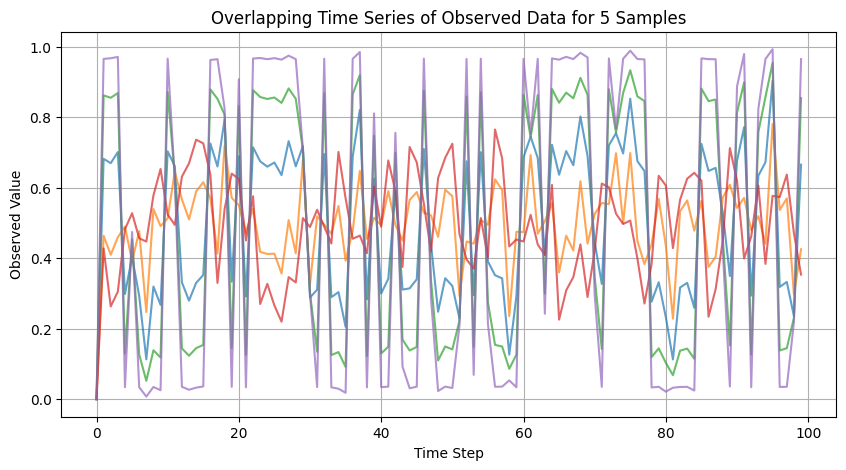

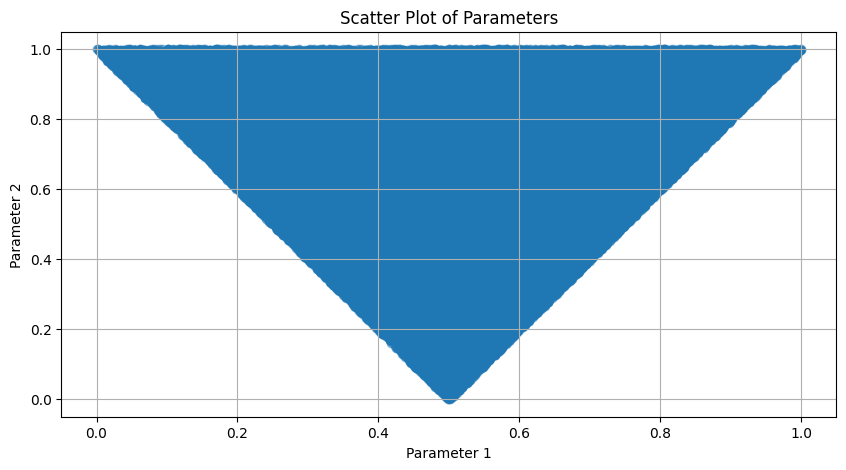

In [5]:
ma2.plot_observation(train_data_norm)
ma2.plot_prior(train_theta_norm)

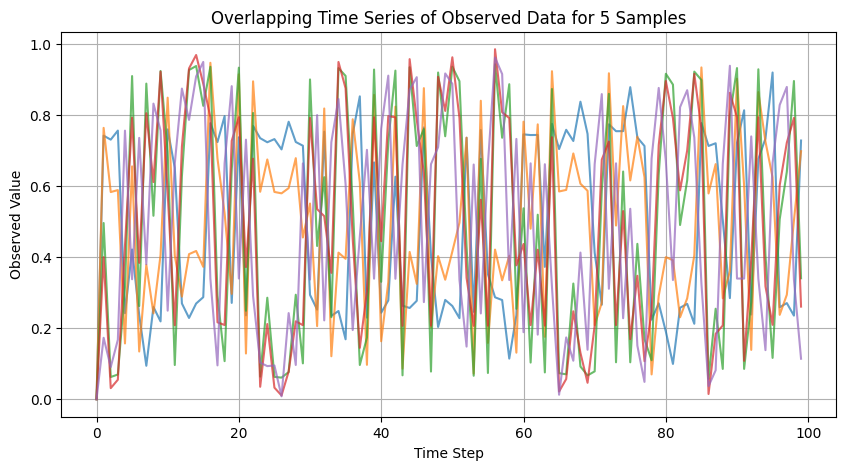

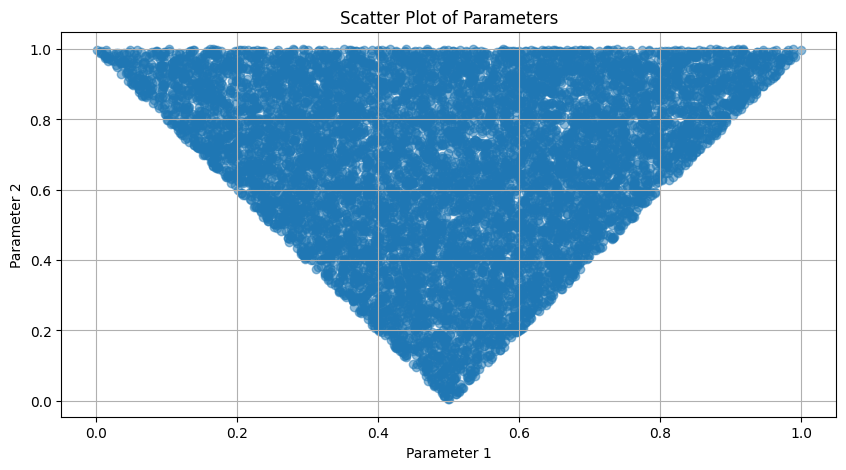

In [6]:
ma2.plot_observation(val_data_norm)
ma2.plot_prior(val_theta_norm)

# Define the CVAE Network

In [7]:
input_dim = 2
latent_dim = 10
conditional_dim = 100
encoder_hidden_dims = [200,200]
decoder_hidden_dims = [200,200]
activation_fn = nn.ReLU()

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn)


optimizer = optim.AdamW(network.parameters(), lr=1e-4)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)

print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=200, out_features=10, bias=True)
    (fc_logvar): Linear(in_features=200, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=110, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU()
    )
    (final_layer): Linear(in_features=200, out_features=2, bias=True)
  )
)


In [8]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=10, 
                    device=device,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= ma2.simulator)

Using CPU for training.
Epoch 1/10: Beta: 0.0, total_loss: 7.1914, recon_loss: 0.1757, misfit_loss: 7.0157, kl_div: 0.3471
Epoch 1/10 Validation: Beta: 0.0, total_loss: 0.4766, recon_loss: 0.0149, misfit_loss: 0.4617, kl_div: 0.4015

Epoch 1: Validation loss improved to 0.0000
Epoch 2/10: Beta: 0.1, total_loss: 0.1428, recon_loss: 0.0034, misfit_loss: 0.1138, kl_div: 0.2567
Epoch 2/10 Validation: Beta: 0.1, total_loss: 0.0444, recon_loss: 0.0008, misfit_loss: 0.0300, kl_div: 0.1373

Epoch 2: Validation loss improved to 0.0000
Epoch 3/10: Beta: 0.2, total_loss: 0.0335, recon_loss: 0.0005, misfit_loss: 0.0209, kl_div: 0.0605
Epoch 3/10 Validation: Beta: 0.2, total_loss: 0.0189, recon_loss: 0.0004, misfit_loss: 0.0148, kl_div: 0.0186

Epoch 3: Validation loss improved to 0.0000
Epoch 4/10: Beta: 0.3, total_loss: 0.0155, recon_loss: 0.0003, misfit_loss: 0.0123, kl_div: 0.0094
Epoch 4/10 Validation: Beta: 0.3, total_loss: 0.0123, recon_loss: 0.0002, misfit_loss: 0.0103, kl_div: 0.0058

Epoc

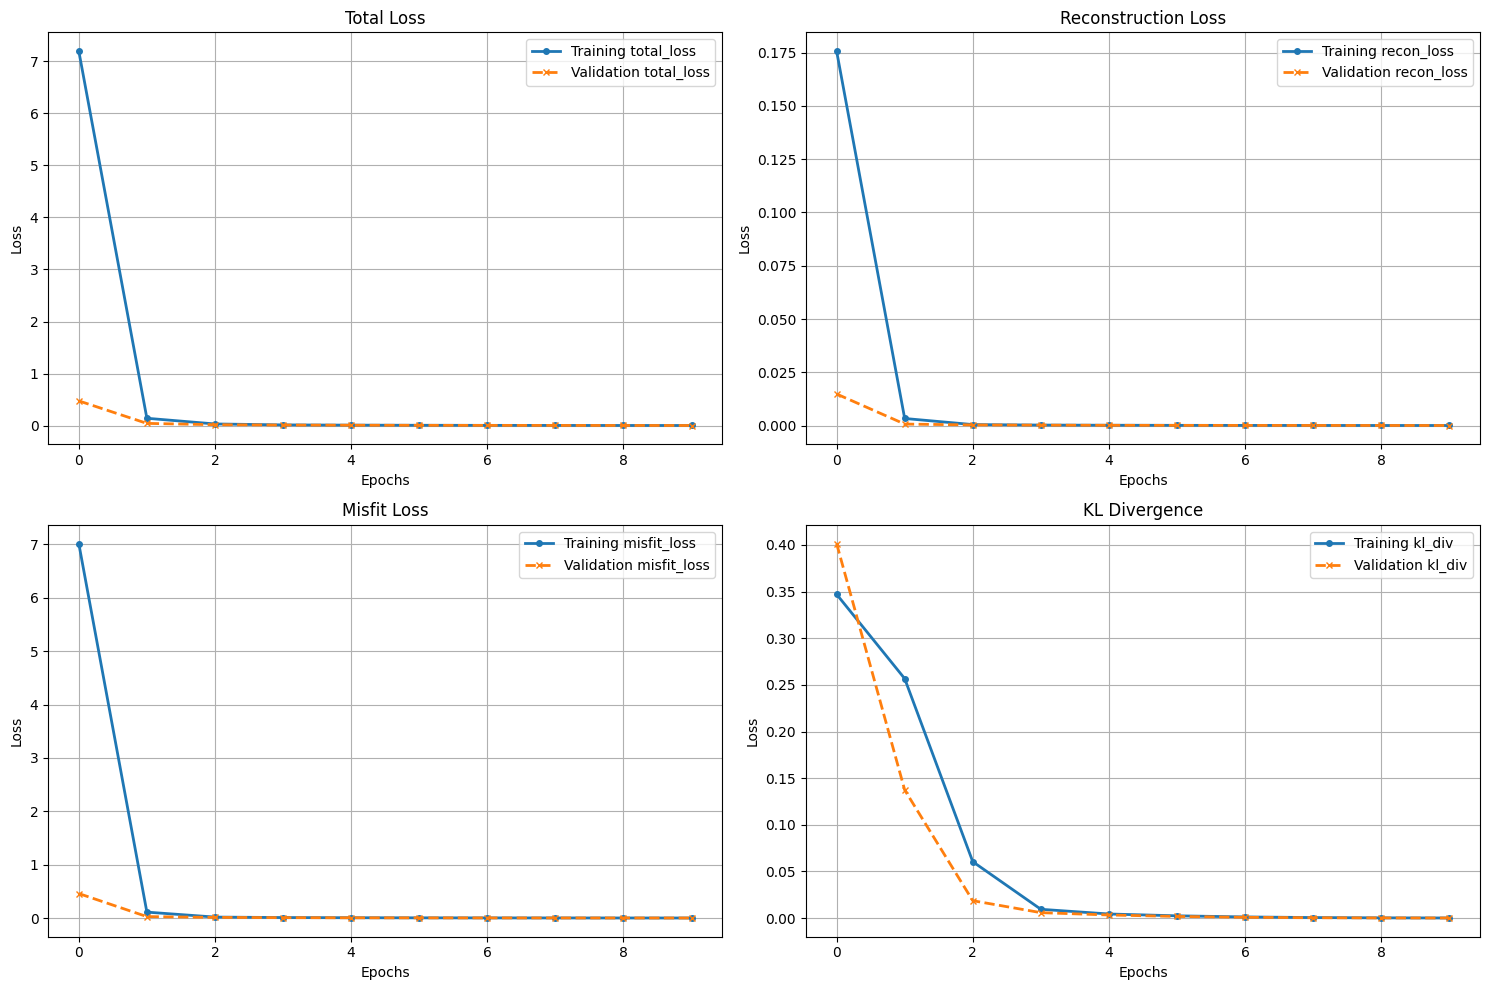

In [9]:
network.plot_loss()

# Inference

In [10]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


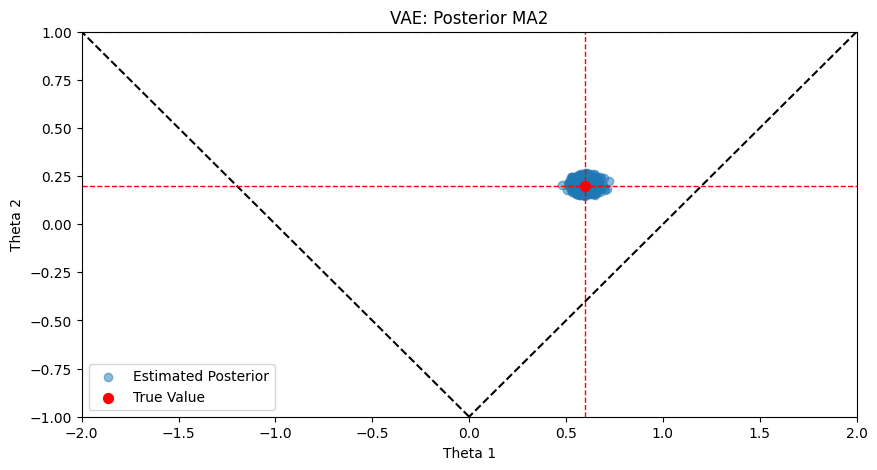

In [11]:
ma2.plot_posterior(post)

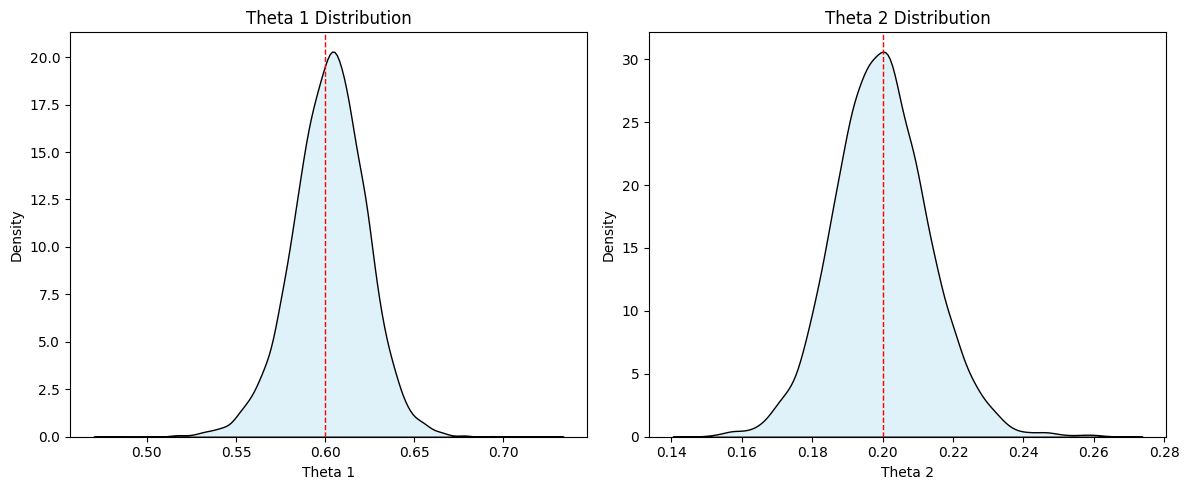

In [12]:
ma2.posterior_hist(post, kde = True)

In [13]:

# def simulator_batch(params, seed=42):
#     """
#     Simulate data using the MA2 model for a batch of parameter sets in parallel.

#     Parameters:
#         params (torch.Tensor): A batch of parameters for the MA2 model, where each row is a set of parameters.
#         seed (int): Seed for random number generation to ensure reproducibility.

#     Returns:
#         torch.Tensor: Batch of simulated data based on the MA2 model, where each row corresponds to the simulation results for a set of parameters.
#     """
#     torch.manual_seed(seed)
    
#     if device is not None:
#         params = params.to(device)
    
#     if params.ndimension() == 1:
#         params = params.unsqueeze(0)
#     n =100
#     # Preparing the random inputs
#     g = torch.randn(n, device=device)
#     gy = torch.randn(n, device=device) * 0.3
    
#     # Expand g to match the batch size and perform batch operations
#     g_expanded = g.expand(params.size(0), n)
#     gy_expanded = gy.expand(params.size(0), n)
    
#     # Initialize the output tensor
#     y = torch.zeros((params.size(0), n), device=device)
    
#     # Apply MA2 model in a vectorized manner
#     for p in range(params.size(1)):
#         if p == 0:
#             y[:, 1:] += g_expanded[:, :-1] * params[:, p:p+1]
#         else:
#             y[:, p+1:] += g_expanded[:, :-p-1] * params[:, p:p+1]
    
#     # Add the original noise and the additional noise term
#     y += g_expanded + gy_expanded
    
#     return y



# def simulator_single(param, seed=42):
#     """
#     Simulate data using the MA2 model.

#     Parameters:
#     - param (torch.Tensor): The parameters for the MA2 model.
#     - seed (int): Seed for random number generation to ensure reproducibility.

#     Returns:
#     - torch.Tensor: Simulated data based on the MA2 model.
#     """
#     torch.manual_seed(seed)
#     n = 100
#     m = len(param)
#     g = torch.randn(n)
#     gy = torch.randn(n) * 0.3
#     y = torch.zeros(n)
#     x = torch.zeros(n)
#     for t in range(n):
#         x[t] += g[t]
#         for p in range(min(t, m)):
#             x[t] += g[t - 1 - p] * param[p]
#         y[t] = x[t] + gy[t]
#     return y

# #param = torch.tensor([0.6,0.8], dtype = torch.float)
# param = ma2.prior(10000)
# print(param.shape)
# seed = 42

# output_single = torch.stack([simulator_single(p, seed) for p in param])
# print("done")
# output_batch = simulator_batch(param, seed)  # Add batch dimension
# print("done")

# # Adjust for batch dimension in output_batch if necessary, e.g., output_batch.squeeze(0)
# are_outputs_equal = torch.allclose(output_single, output_batch.squeeze(0), atol=1e-2)

# print(f"Outputs are {'the same' if are_outputs_equal else 'different'}.")


In [14]:
output_single

NameError: name 'output_single' is not defined

In [ ]:
output_batch

tensor([[ 2.1448,  1.7868,  1.6975,  ..., -0.1022,  0.1404,  0.4945],
        [ 2.1448, -0.8236,  0.6130,  ...,  1.0875, -0.5029,  0.0801],
        [ 2.1448,  3.2937,  2.1587,  ..., -0.7631,  0.5961,  0.7232],
        ...,
        [ 2.1448, -0.2907,  1.0912,  ...,  0.8041, -0.5031,  0.1811],
        [ 2.1448, -0.8414,  0.8785,  ...,  1.0526, -0.6470,  0.0947],
        [ 2.1448,  3.7137,  3.9038,  ..., -1.2020, -0.1044,  0.8904]])